# Shampoo Sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import darts
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

from timeseries_utils import (
    timeseries_csv_to_df,
    split_train_test,
    plot_results,
    eval_darts_model,
)

Importing plotly failed. Interactive plots will not work.


We will again be using DARTS as the main library in this analysis as we did with the Minimum Temperature example, so we need to load first the data as a DataFrame and then transform it into a TimeSeries object.

In [2]:
# Preparing the dataset to be loaded as TimeSeries
df = pd.read_csv("../data/sales-of-shampoo-over-a-three-ye.csv")
df["Month"] = pd.to_datetime("200" + df["Month"])

In [3]:
shampoo_timeseries = TimeSeries.from_dataframe(
    df,
    time_col="Month",
    freq="MS"
)

And we split it into train and test sets:

In [4]:
train_split = pd.Timestamp(year=2003, month=6, day=1)
shampoo_train, shampoo_test = shampoo_timeseries.split_before(train_split)

## Dataset Description 

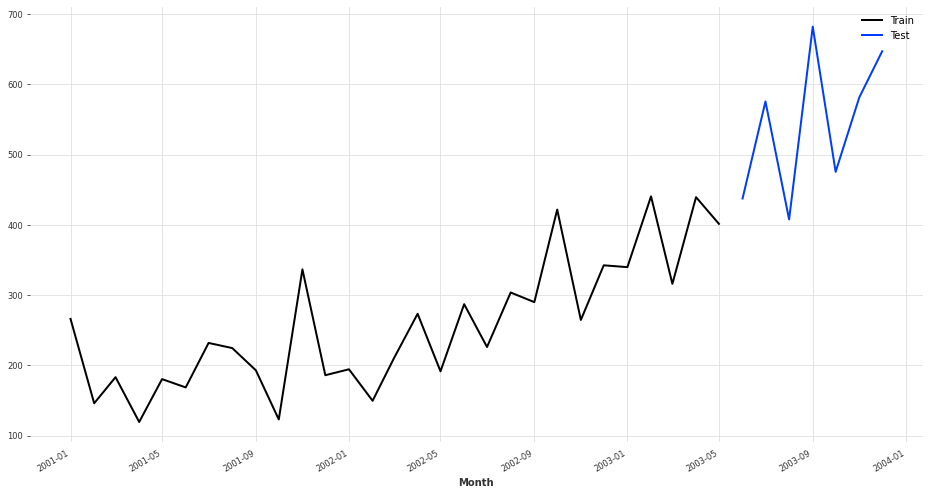

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
shampoo_train.plot(label="Train")
shampoo_test.plot(label="Test")
plt.show()

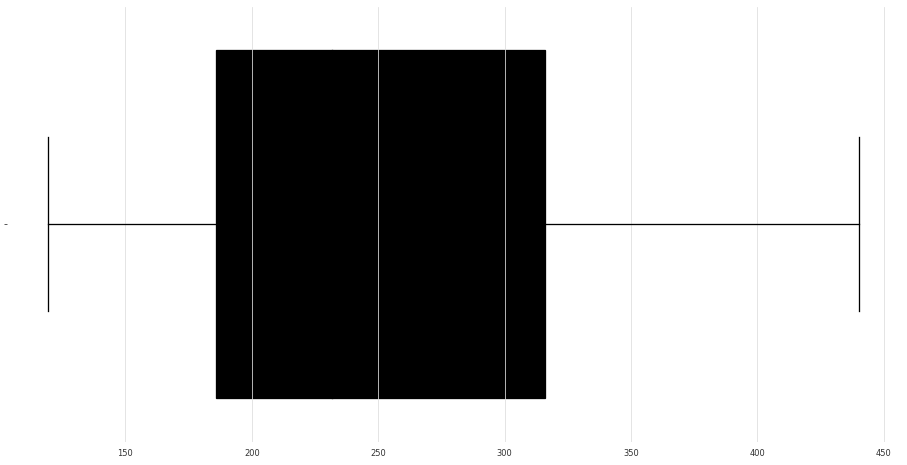

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(shampoo_train.all_values(), ax=ax)
plt.show()

In [7]:
for i in range(2, 13):
    is_seasonal, m = check_seasonality(shampoo_train, i)
    if is_seasonal:
        print(f"The dataset has a seasonality of degree {m}")

The dataset has a seasonality of degree 2
The dataset has a seasonality of degree 4
The dataset has a seasonality of degree 6


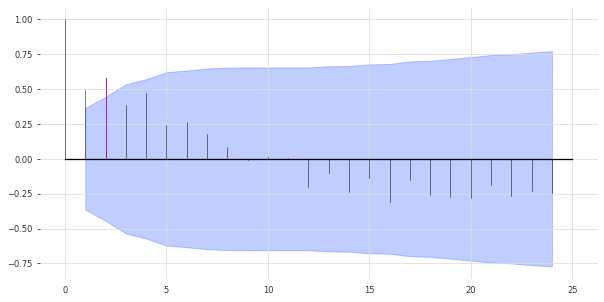

In [8]:
plot_acf(shampoo_train, m=2)

## Dataset Transformation 

In [9]:
box_transformer = BoxCox()
shampoo_box = box_transformer.fit_transform(shampoo_timeseries)

In [10]:
values = shampoo_box.values()

# differencing timeseries
ts_diff = shampoo_box.diff()

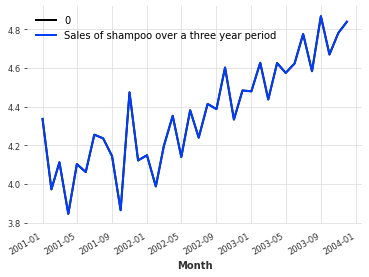

In [11]:
values = shampoo_box.values()

# differencing timeseries
ts_diff = shampoo_box.diff()

values_diff = ts_diff.values()

# because the value of the first timestep is lost during differencing we can insert it back in to get the correct y-offset if we know it
values_diff = np.insert(values_diff, 0, values[0])

# use np.cumsum to calculate the cumulative sum of the differenced values (inverting differencing)
values_undiff = np.cumsum(values_diff)

# build the reconstructed timeseries from the values_undiff and the original time_index
ts_undiff = TimeSeries.from_times_and_values(shampoo_timeseries.time_index, values_undiff)

# plot both series to check for equivalence
ts_undiff.plot()
shampoo_box.plot()
plt.show()

## Forecasting

In [12]:
train_split = pd.Timestamp(year=2003, month=6, day=1)
shampoo_train, shampoo_test = shampoo_timeseries.split_before(train_split)

In [13]:
models = [
    NaiveSeasonal(K=2),
    NaiveDrift(),
    Prophet(yearly_seasonality=False,
            daily_seasonality=False,
            weekly_seasonality=False,
            n_changepoints=6),
    ExponentialSmoothing(),
]

In [14]:
for model in models:
    eval_darts_model(model, shampoo_train, shampoo_test, mae)

The error of the model is: 130.29999999999998
The error of the model is: 125.42755102040813
The error of the model is: 135.26839805694044
The error of the model is: 83.91589151857129


In [15]:
model = ExponentialSmoothing()
model.fit(shampoo_train)
prediction = model.predict(len(shampoo_test))

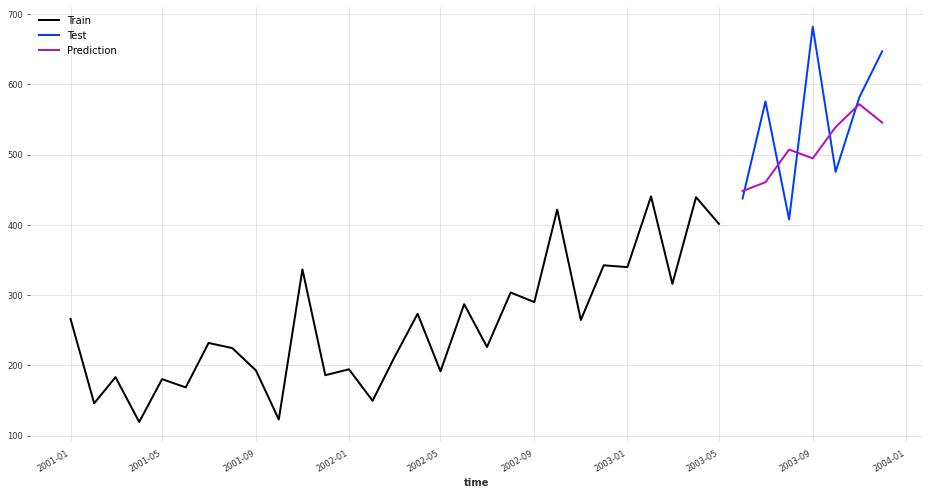

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
shampoo_train.plot(label='Train')
shampoo_test.plot(label='Test')
prediction.plot(label='Prediction')
plt.show()